# Исследование данных о продаже компьютерных игр

Исследование данных интернет-магазина «Стримчик» о продаже игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Цель исследования: выявить закономерности определяющие успешность игры, что позволит вкладывать усилия в потенциально популярный продукт и спланировать рекламные кампании.

## Общая информация.

In [1]:
# Импортируем библиотеки, которые нам понадобятся в исследовании
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from string import ascii_letters
import plotly.express as px
from scipy import stats as st


sns.set_style("whitegrid")

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN

### Описание данных
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг ESRB (англ. Entertainment Software Rating Board). Ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [3]:
data.duplicated().sum()

0

## Подготовка данных

In [4]:
# приведу названия столбцов к нижнему регистру;
data.columns = data.columns.str.lower()
# проверю тип данных в столбцах
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Изменение типа данных и работа с пропусками
Для того чтобы изменить тип данных нужно заплолнить пропуски, проверим есть ли они.

In [5]:
# удалю пропущенные значения в столбце'year_of_release' и 'name'
data=data.loc[data['year_of_release'].notna()]
data=data.loc[data['name'].notna()]

In [6]:
# проверю количество пропущенных значений в датасете
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

In [7]:
# изменю тип данных в столбцах 'user_score' и 'year_of_release'
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
data['year_of_release']=pd.to_datetime(data['year_of_release'], format='%Y')
data['year_of_release'] = data['year_of_release'].dt.year

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [9]:
# посчитаю суммарные продажи во всех регионах и запишите их в отдельный столбец.
data['total']=data['na_sales']+data['eu_sales']+data['jp_sales']+data['other_sales']
data.head()

name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii             2006        Sports     41.36   
1         Super Mario Bros.      NES             1985      Platform     29.08   
2            Mario Kart Wii      Wii             2008        Racing     15.68   
3         Wii Sports Resort      Wii             2009        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB             1996  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score  user_score rating  total  
0     28.96      3.77         8.45          76.0         8.0      E  82.54  
1      3.58      6.81         0.77           NaN         NaN    NaN  40.24  
2     12.76      3.79         3.29          82.0         8.3      E  35.52  
3     10.93      3.28         2.95          80.0         8.0      E  32.77  
4      8.89     10.22         1.00           NaN         NaN    NaN  31.38

#### Вывод по подготовке данных
Пропущенные строки в столбцах 'year_of_release', 'name' и 'genre' заменить не смогу.
Год релиза не заменишь средним или медианой — это бессмысленно.
Как не найти название или жанр. Данные могли быть потеряны при сборе или обрабоке.
Пропуски в столбцах 'critic_score', 'user_score' и 'rating' могут быть сввязаны с отсутствием данных,
так как не все пользователи отсаляют оценки и, видимо, не всем играм присваивался рейтинг.
Также оценок может быть недостатоно для того, чтобы оценка отобразилась на платформе.

Сокращение "tbd" в данных скорее всего озанчает — To Be Determined, то есть оценку предстоит определить.


In [10]:
# Комментарий ревьюера
# Посмотрим, что у нас осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
 11  total            16444 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

## Исследовательский анализ

### Количество игр выпущенное в разные годы

<AxesSubplot:xlabel='year_of_release'>

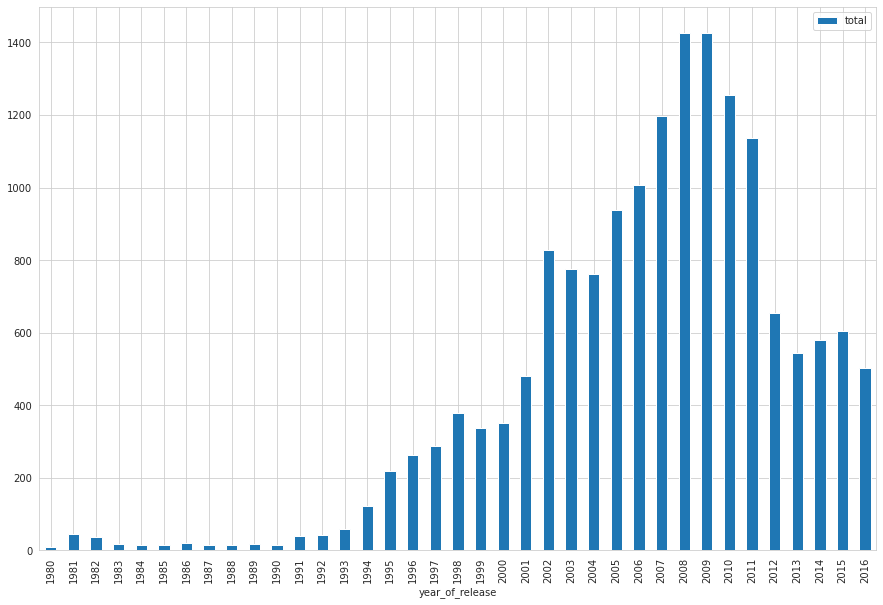

In [11]:
# построим гистограмму отображающую количество выпущенных игр по годам
# данные соберем с помощью сводной таблицы
data_pivot=data.pivot_table(index=['year_of_release'], 
                            values=['name','total'],
                            aggfunc={'name':'count','total':'count'})
data_pivot.columns=['count','total']
data_pivot.sort_index().plot(kind='bar',y='total', grid=True,figsize=(15,10))

#### Вывод:
По графику видно что количество игр выпускаемых на платформах выросло почти в двое в 2002 году, возможно, данные нужно рассматривать именно с 2002 года.

### Изменения продаж по платформам

<AxesSubplot:xlabel='platform'>

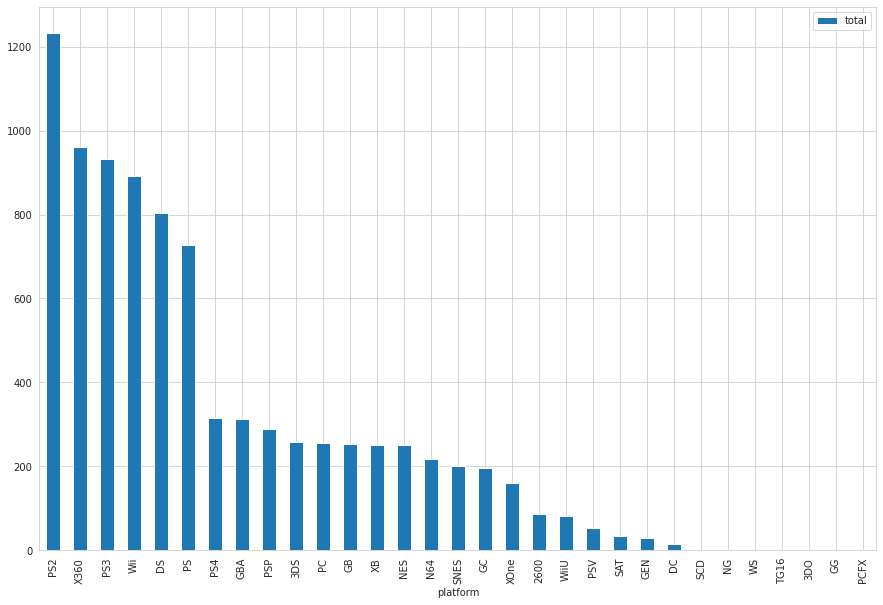

In [12]:
# выбираю платформы с наибольшими суммарными продажами
data_platform=data.pivot_table(index=['platform'], 
                               values=['name','total'],
                               aggfunc={'name':'count','total':'sum'})
data_platform.columns=['count','total']
data_platform.sort_values(by='total',ascending=False).plot(kind='bar',y='total', grid=True,figsize=(15,10))


#### Вывод
Плытформы с большими суммарными продажами:
- PS2 
- X360
- PS3
- Wii
- DS
- PS

<AxesSubplot:xlabel='year_of_release', ylabel='total'>

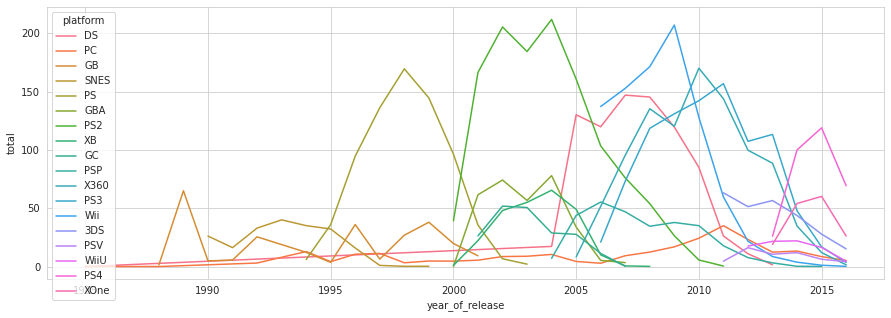

In [13]:
# Построю распределение продаж на основных платформах по годам

platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 
             'GBA', 'PSP', '3DS', 'PC', 'GB', 'XB', 'SNES', 
             'GC', 'XOne', 'WiiU', 'PSV']
top_platforms = data[data['platform'].isin(platforms)]
top_platform_pivot = top_platforms.pivot_table(index=['year_of_release', 'platform'],
                                             values='total', aggfunc='sum')

top_platform_pivot = top_platform_pivot.reset_index()
plt.figure(figsize=(15,5))
sns.lineplot(x='year_of_release', y='total', hue='platform', data=top_platform_pivot)

Судя по графику новые платформы заменяют старые раз в 10 лет

### Актуальный период

In [14]:
data.pivot_table(index='platform', 
                 values='year_of_release', 
                 aggfunc='nunique').sort_values(by='year_of_release', ascending=False)

year_of_release
platform                 
PC                     26
GB                     13
NES                    12
X360                   12
PSP                    12
PS2                    12
Wii                    11
DS                     11
PS3                    11
2600                   10
SNES                   10
PS                     10
XB                      9
GBA                     8
DC                      7
GC                      7
N64                     7
SAT                     6
3DS                     6
PSV                     6
WiiU                    5
GEN                     5
NG                      4
PS4                     4
XOne                    4
WS                      3
SCD                     2
3DO                     2
TG16                    1
GG                      1
PCFX                    1

#### Вывод
Актуальный период, который позволит построить прогноз на 2017 год начиается в 2013 году.

In [15]:
# отфильтрую данные до 2013 года

data = data[data['year_of_release'] >= 2013]
print(len(data[data['year_of_release'] < 2013]))

0


In [16]:
# построю график продаж по платформам

platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 
             'PS4', 'GBA', 'PSP', '3DS', 'PC', 'GB', 
             'XB', 'SNES', 'GC', 'XOne', 'WiiU', 'PSV']
next_platforms = data[data['platform'].isin(platforms)]
next_platforms_pivot = next_platforms.pivot_table(index=['year_of_release', 'platform'],
                                             values='total', aggfunc='sum')

next_platforms_pivot = next_platforms_pivot.reset_index()

fig = px.line(next_platforms_pivot, x="year_of_release", y="total", color='platform')
fig.show()

In [17]:
# список потенциально прибыльных платформ
# опираясь на график выше
best_platforms = ['PS4', '3DS', 'PS3', 'X360', 'PC', 'Wii', 'XOne', 'WiiU', 'PSV']

### График «ящик с усами»

In [18]:
data['platform'].unique()


array(['PS3', 'X360', 'PS4', '3DS', 'XOne', 'WiiU', 'Wii', 'PC', 'PSV',
       'DS', 'PSP'], dtype=object)

(0.0, 5.0)

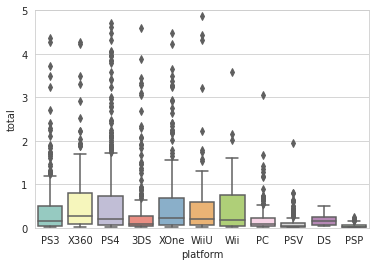

In [19]:
fig = sns.boxplot(x='platform', y='total', data=data, palette='Set3')
fig.set_figsize=(17,5)
fig.set_ylim(0, 5)

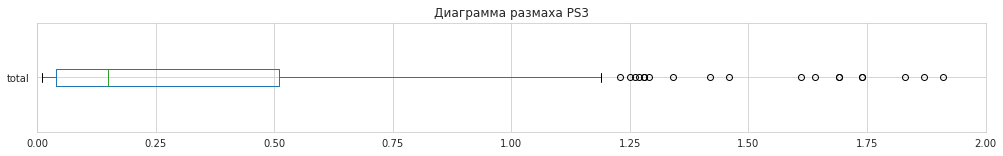

In [20]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[data['platform'] == 'PS3'][['platform', 'total']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха PS3')
ax.set_xlim(0, 2);


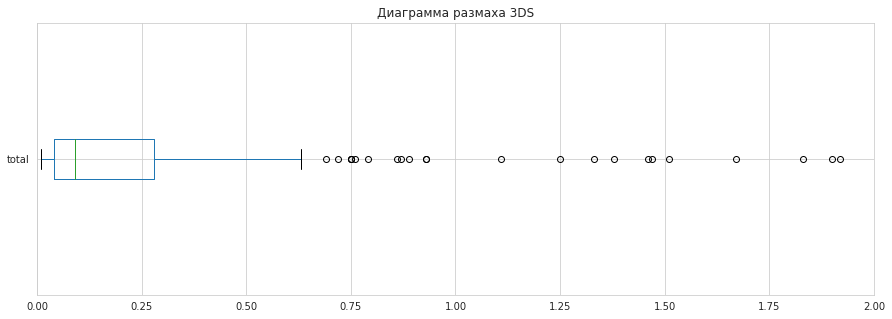

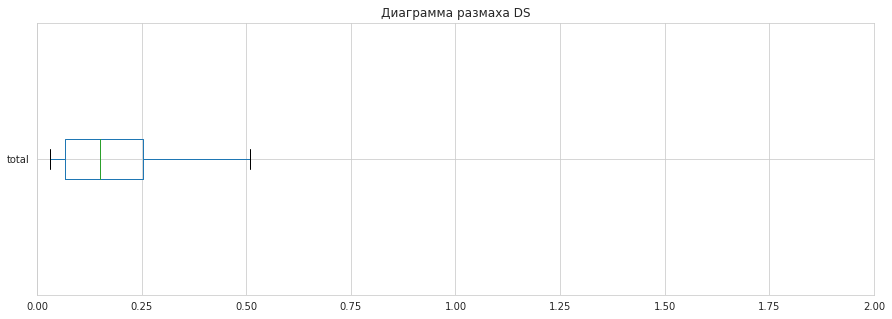

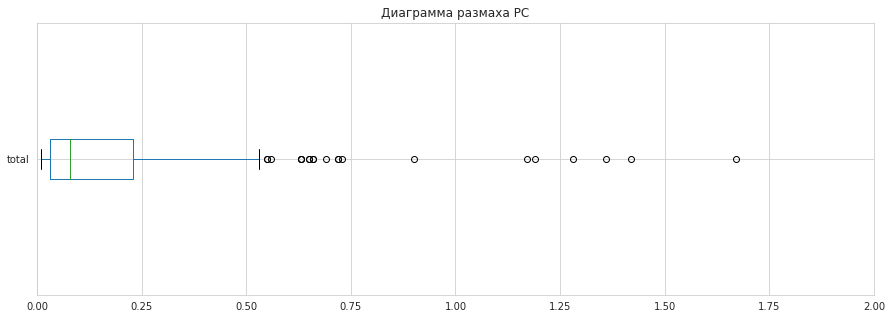

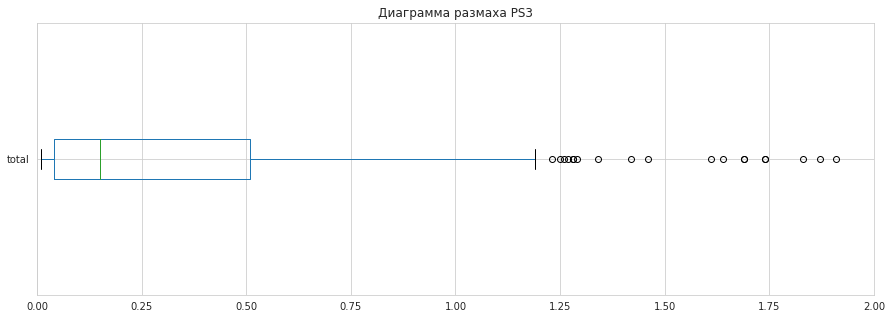

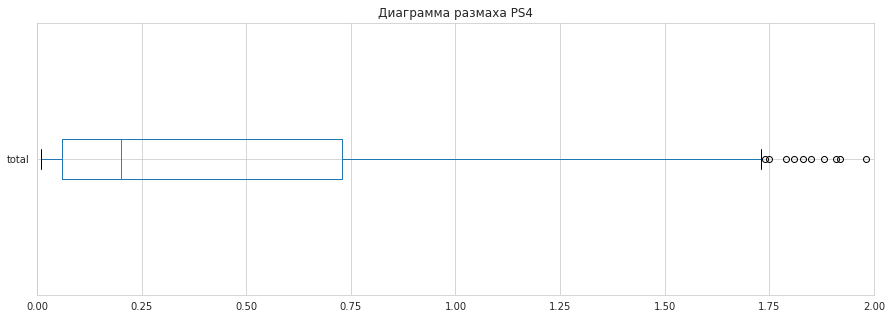

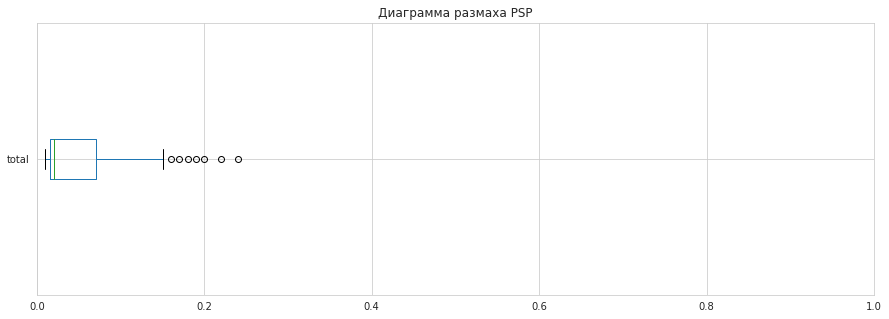

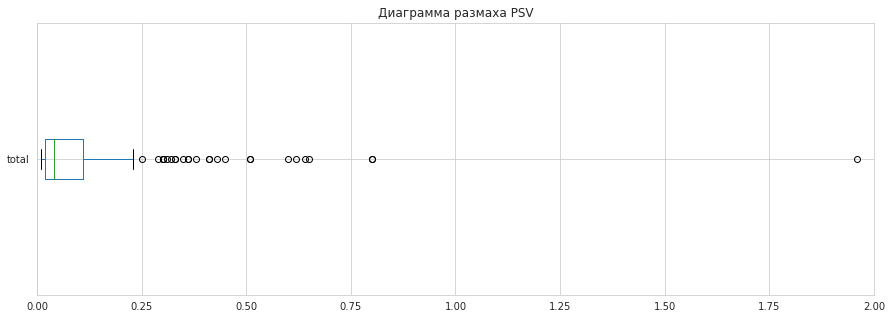

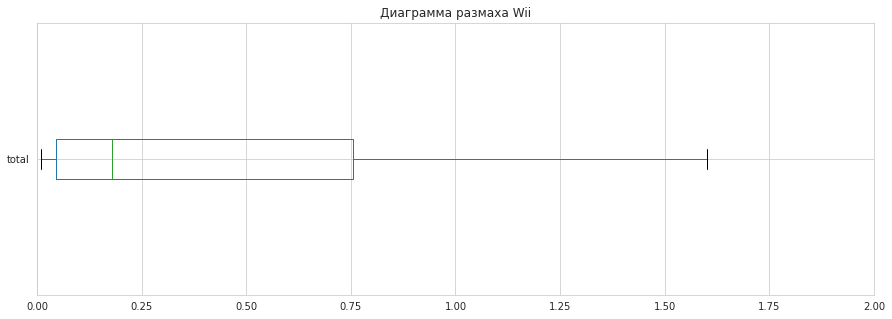

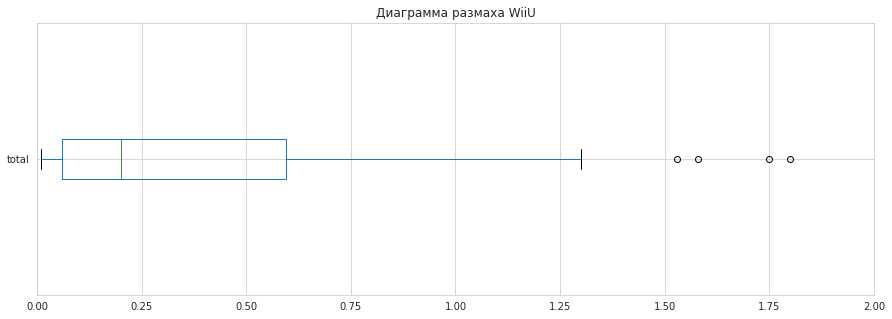

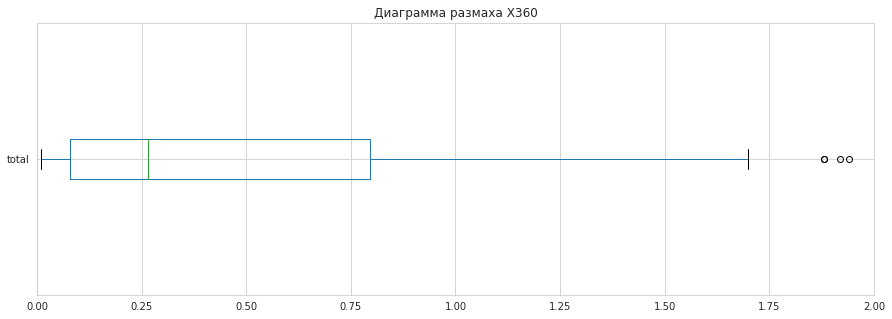

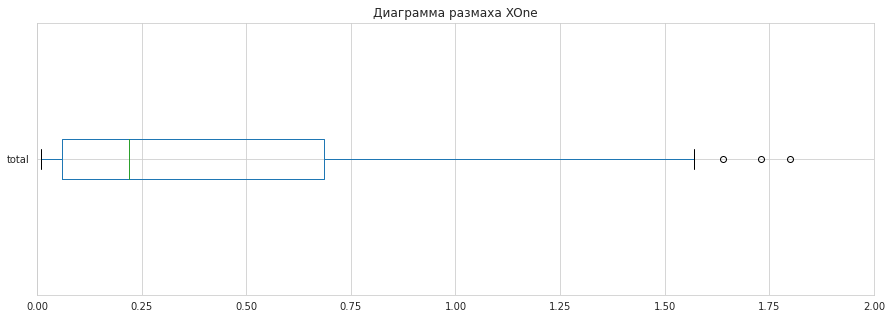

In [21]:
limits = {'PS3': (0, 2),
         'X360': (0, 2), 
         'PS4': (0, 2), 
         '3DS': (0, 2),
         'XOne': (0, 2),
         'WiiU': (0, 2),
         'Wii': (0, 2),
          'PC': (0, 2),
          'PSV': (0, 2),
          'DS': (0, 2),
          'PSP': (0, 1)}

for col, dt in data[['platform', 'total']].groupby('platform'):
    dt.plot(kind='box', vert=False, figsize=(15, 5))
    plt.title('Диаграмма размаха ' + col)
    if col in limits.keys():
        plt.xlim(limits[col]);
    plt.show()

In [22]:
d_desc = pd.DataFrame()
for col, dt in data[['platform', 'total']].groupby('platform'):
    tmp = dt[['total']].describe().T.reset_index()
    tmp['platform'] = col
    d_desc = pd.concat([d_desc, tmp])
d_desc

index  count      mean       std   min     25%    50%     75%    max  \
0  total  303.0  0.472772  1.381347  0.01  0.0400  0.090  0.2800  14.60   
0  total    8.0  0.192500  0.172026  0.03  0.0675  0.150  0.2525   0.51   
0  total  189.0  0.208624  0.352304  0.01  0.0300  0.080  0.2300   3.05   
0  total  345.0  0.525884  1.451939  0.01  0.0400  0.150  0.5100  21.05   
0  total  392.0  0.801378  1.609456  0.01  0.0600  0.200  0.7300  14.63   
0  total   67.0  0.052239  0.059768  0.01  0.0150  0.020  0.0700   0.24   
0  total  358.0  0.092151  0.153816  0.01  0.0200  0.040  0.1100   1.96   
0  total   23.0  0.593913  0.915432  0.01  0.0450  0.180  0.7550   3.58   
0  total  115.0  0.562000  1.038778  0.01  0.0600  0.200  0.5950   7.09   
0  total  186.0  0.735484  1.663275  0.01  0.0800  0.265  0.7950  16.27   
0  total  247.0  0.645020  1.036139  0.01  0.0600  0.220  0.6850   7.39   

  platform  
0      3DS  
0       DS  
0       PC  
0      PS3  
0      PS4  
0      PSP  
0      PSV  
0      Wii  
0     WiiU  
0     X360  
0     XOne

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkMagenta'>👉 Лучше строить диаграммы на одной координатной сетке.</font>

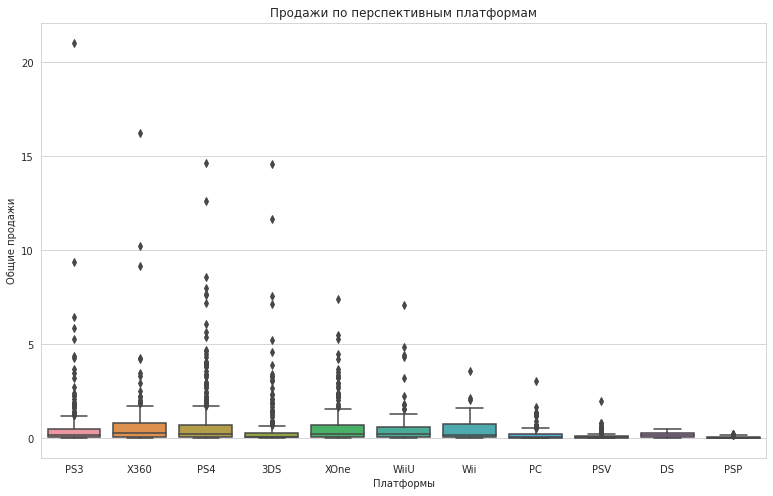

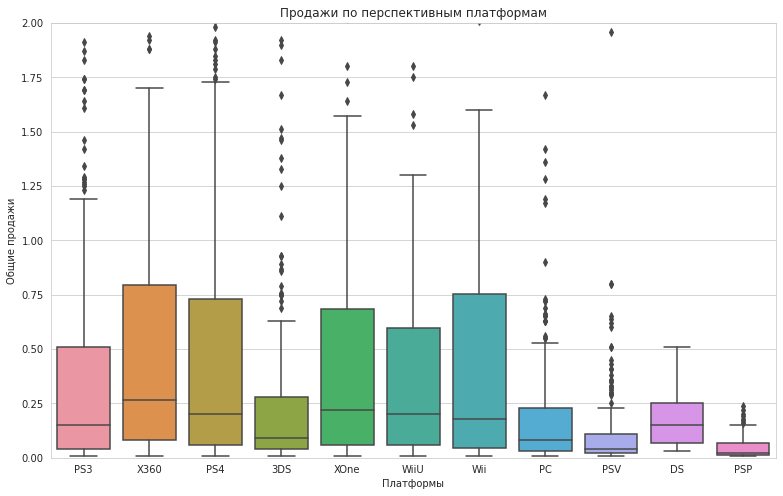

In [23]:
# Комментарий ревьюера 2
import seaborn as sns
data_temp, y = data, 'total'
plt.figure(figsize=(13, 8))
(sns.boxplot(data = data_temp, y = y, x='platform')
    .set(title = 'Продажи по перспективным платформам', xlabel = 'Платформы', ylabel = 'Общие продажи'))
plt.show()
plt.figure(figsize=(13, 8))
(sns.boxplot(data = data_temp, y = y, x='platform')
    .set(title = 'Продажи по перспективным платформам', xlabel = 'Платформы', ylabel = 'Общие продажи', ylim=(0, 2)))
plt.show()

#### Вывод
По графикам и описанием данных делаю вывод что самые прибыльные платформы:
- X360
- XOne
- WiiU
- PS4
- Wii

### Зависимость продаж платформ от отзывы пользователей и критиков

3DS



user_score     total
user_score    1.000000  0.241504
total         0.241504  1.000000

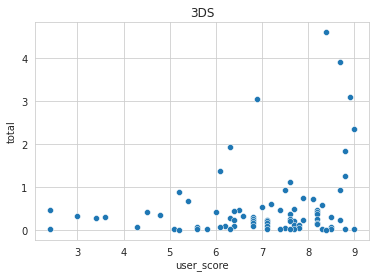

----------
PC



user_score     total
user_score    1.000000 -0.093842
total        -0.093842  1.000000

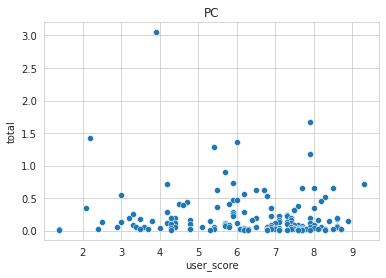

----------
PS3



user_score     total
user_score    1.000000  0.002394
total         0.002394  1.000000

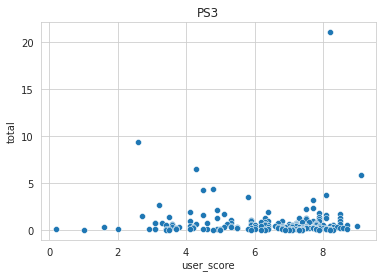

----------
PS4



user_score     total
user_score    1.000000 -0.031957
total        -0.031957  1.000000

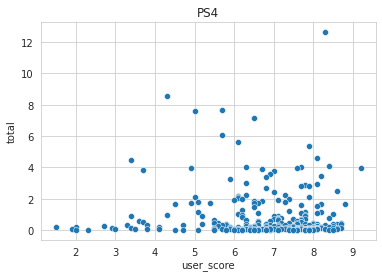

----------
PSV



user_score     total
user_score    1.000000  0.000942
total         0.000942  1.000000

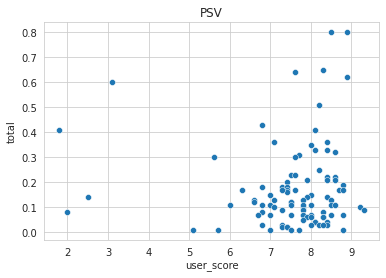

----------
WII



user_score     total
user_score    1.000000  0.682942
total         0.682942  1.000000

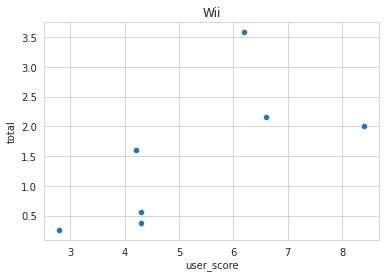

----------
WIIU



user_score    total
user_score     1.00000  0.41933
total          0.41933  1.00000

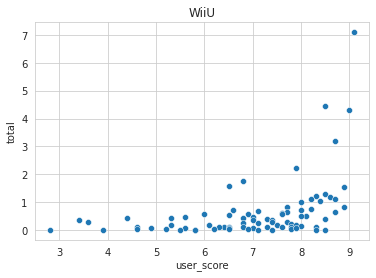

----------
X360



user_score     total
user_score    1.000000 -0.011742
total        -0.011742  1.000000

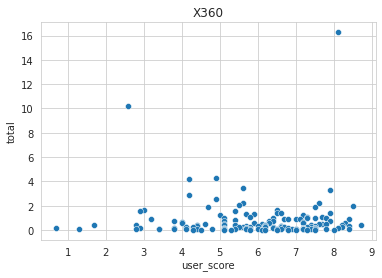

----------
XONE



user_score     total
user_score    1.000000 -0.068925
total        -0.068925  1.000000

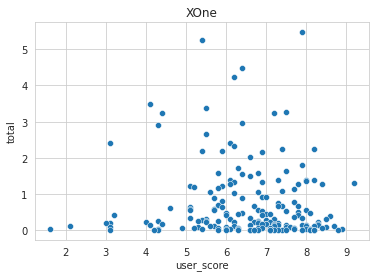

----------


In [24]:
for column, score_data in data[data['platform'].isin(best_platforms)].groupby('platform'):
    print(column.upper())
    print()
    d1 = score_data[['user_score', 'total']].copy()

    display(d1[['user_score', 'total']].corr())
    sns.scatterplot(data=d1, x='user_score', y='total')
    plt.title(column)
    plt.show()
    print('--' * 5)

3DS



critic_score     total
critic_score      1.000000  0.357057
total             0.357057  1.000000

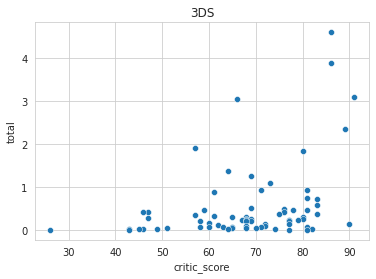

----------
PC



critic_score    total
critic_score       1.00000  0.19603
total              0.19603  1.00000

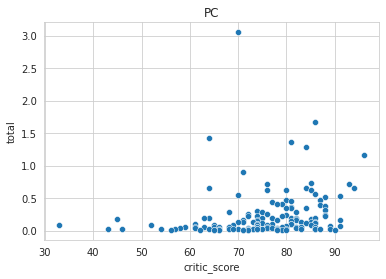

----------
PS3



critic_score     total
critic_score      1.000000  0.334285
total             0.334285  1.000000

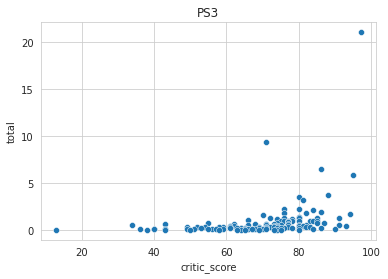

----------
PS4



critic_score     total
critic_score      1.000000  0.406568
total             0.406568  1.000000

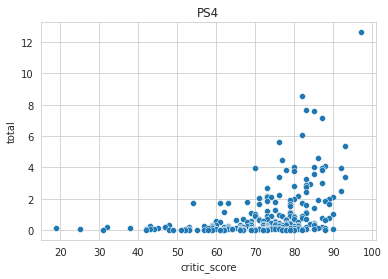

----------
PSV



critic_score     total
critic_score      1.000000  0.254742
total             0.254742  1.000000

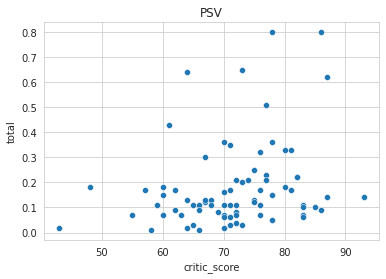

----------
WII



critic_score  total
critic_score           NaN    NaN
total                  NaN    1.0

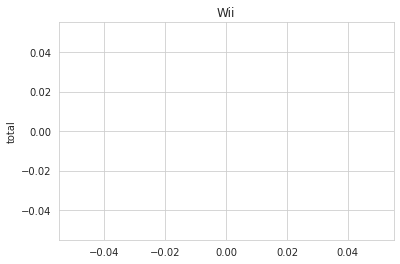

----------
WIIU



critic_score     total
critic_score      1.000000  0.376415
total             0.376415  1.000000

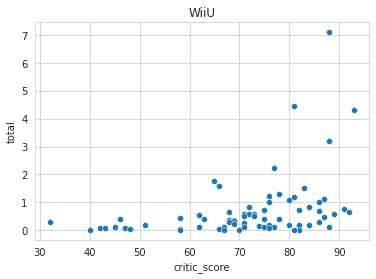

----------
X360



critic_score     total
critic_score      1.000000  0.350345
total             0.350345  1.000000

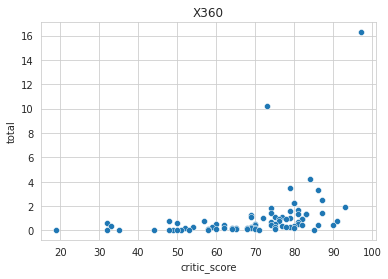

----------
XONE



critic_score     total
critic_score      1.000000  0.416998
total             0.416998  1.000000

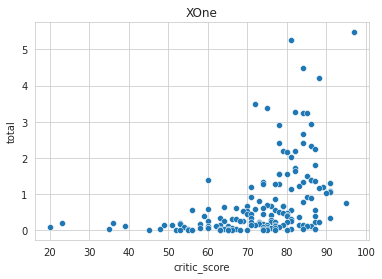

----------


In [25]:
for column, score_data in data[data['platform'].isin(best_platforms)].groupby('platform'):
    print(column.upper())
    print()

    d2 = score_data[['critic_score', 'total']].copy()

    display(d2[['critic_score', 'total']].corr())
    sns.scatterplot(data=d2, x='critic_score', y='total')
    plt.title(column)
    plt.show()
    print('--' * 5)

Рейтирнг критиков влияет на продажи на всех платформах, рейтинг пользователей имеет меньшее влияние, чем рейтинг критиков.
На большей части платформ рейтинг пользователей минимально влияет на продажи.
Исключением является платформа — WIIU, где рейтинг пользователей влияет на продажи больше рейтинга критиков,
и имеет наибольший коэфициент корреляции среди всех платформ.

### Распределение игр по жанрам

In [26]:
data['genre'].unique()

array(['Action', 'Shooter', 'Role-Playing', 'Misc', 'Sports', 'Fighting',
       'Racing', 'Simulation', 'Platform', 'Strategy', 'Adventure',
       'Puzzle'], dtype=object)

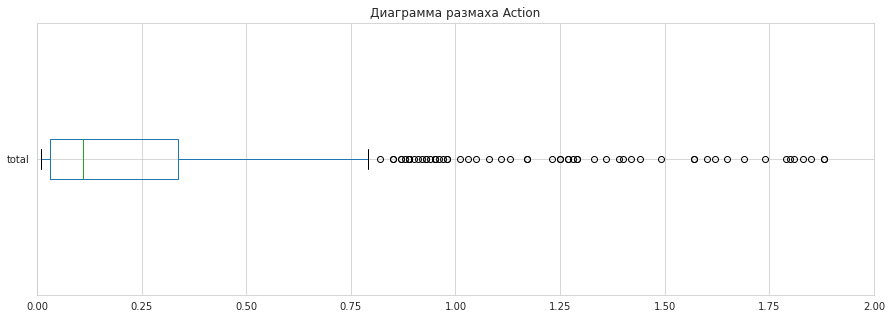

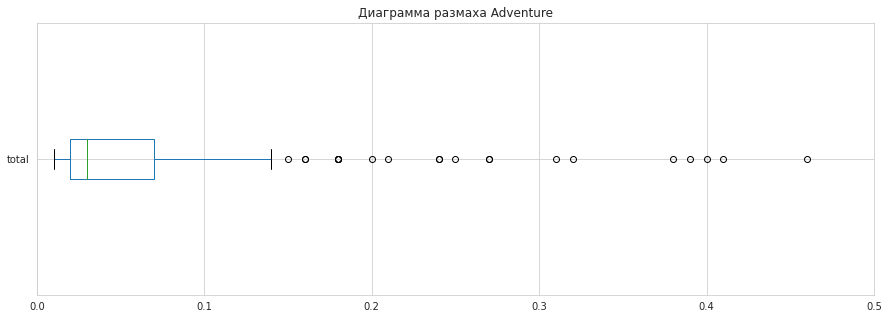

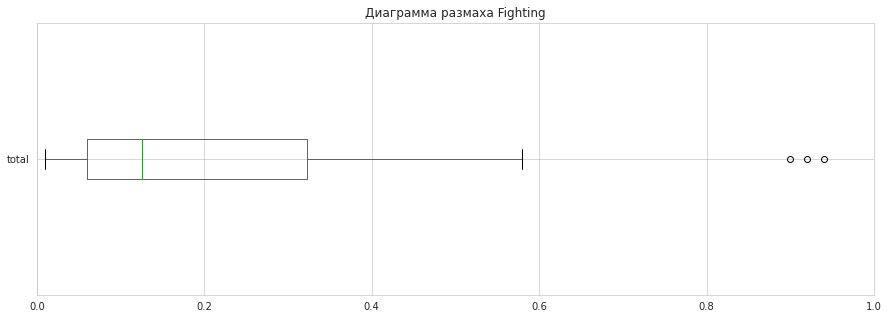

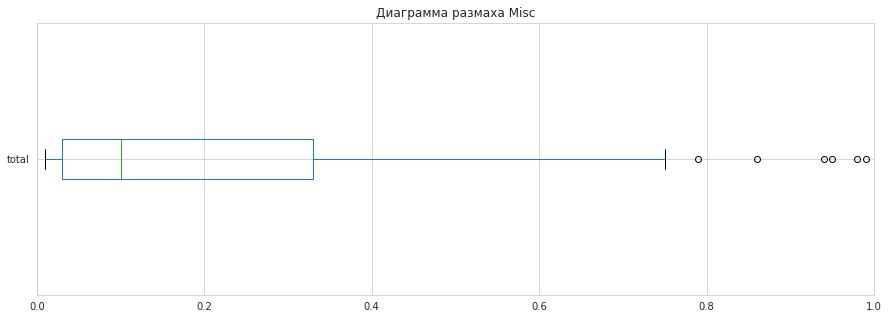

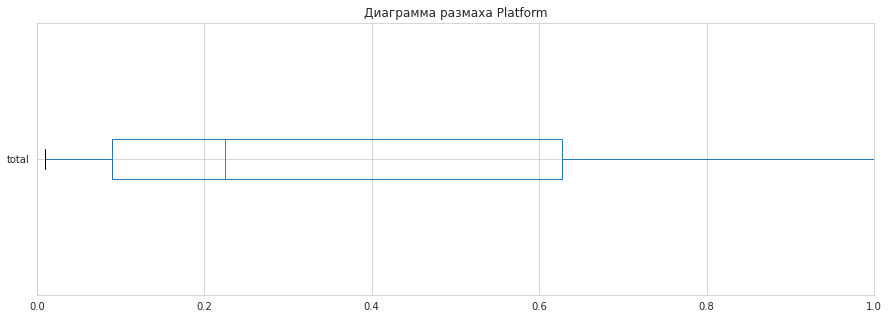

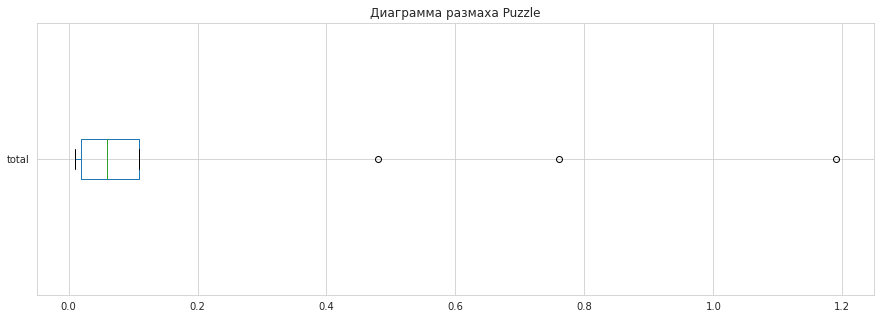

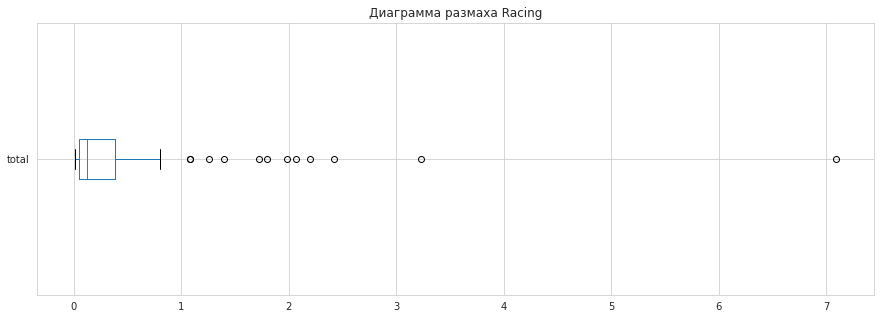

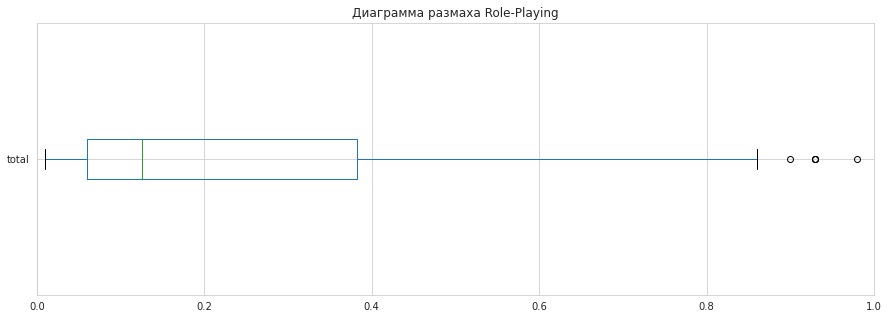

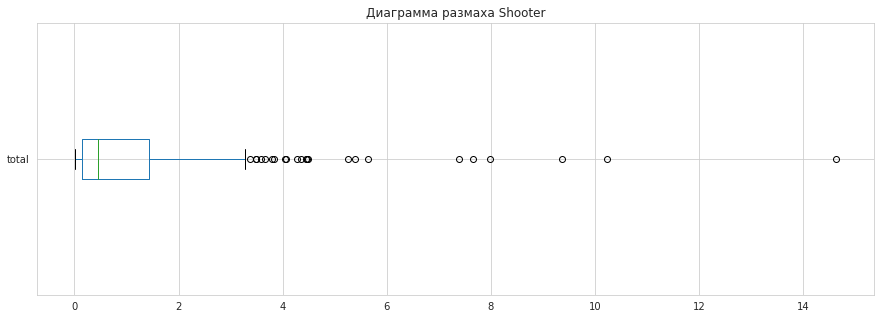

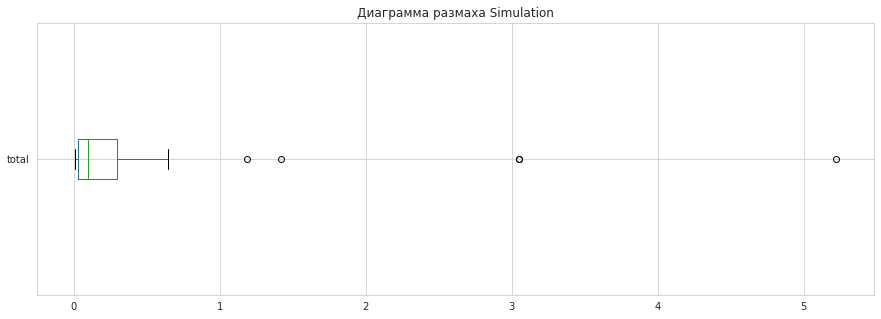

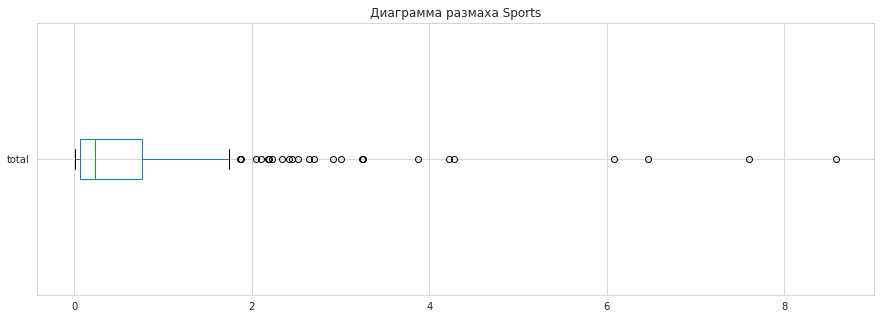

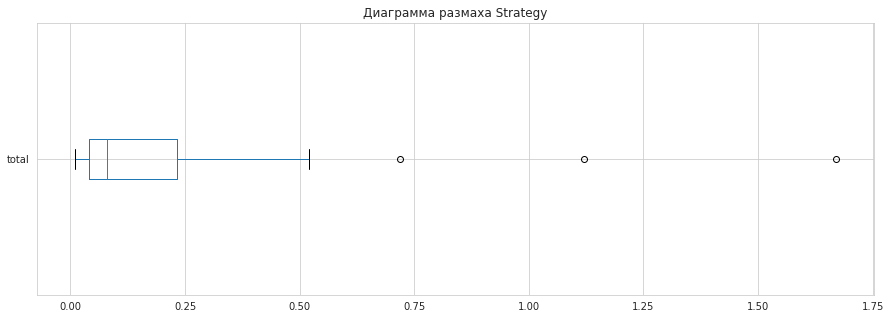

In [27]:
# найдем самые прибыльные жанры

limits = {'Action': (0, 2),
          'Adventure': (0, 0.5),
          'Fighting': (0, 1), 
          'Misc': (0, 1),
          'Platform': (0, 1),
          'Role-Playing': (0, 1)
         }

for col, dt in data[['genre', 'total']].groupby('genre'):
    dt.plot(kind='box', vert=False, figsize=(15, 5))
    plt.title('Диаграмма размаха ' + col)
    if col in limits.keys():
        plt.xlim(limits[col]);
    plt.show()

In [28]:
genre=data.groupby(['genre'], as_index=False).agg({'total':['sum','count','mean','median','max']})
genre.columns=['genre','total','count','mean','median','max']
print(genre.sort_values('median', ascending=False))

           genre   total  count      mean  median    max
8        Shooter  232.98    187  1.245882   0.450  14.63
10        Sports  150.65    214  0.703972   0.240   8.58
4       Platform   42.63     74  0.576081   0.225   4.32
7   Role-Playing  145.89    292  0.499623   0.125  14.60
2       Fighting   35.31     80  0.441375   0.125   7.55
6         Racing   39.89     85  0.469294   0.120   7.09
0         Action  321.87    766  0.420196   0.110  21.05
9     Simulation   21.76     62  0.350968   0.100   5.22
3           Misc   62.82    155  0.405290   0.100   9.18
11      Strategy   10.08     56  0.180000   0.080   1.67
5         Puzzle    3.17     17  0.186471   0.060   1.19
1      Adventure   23.64    245  0.096490   0.030   1.66


<AxesSubplot:ylabel='total'>

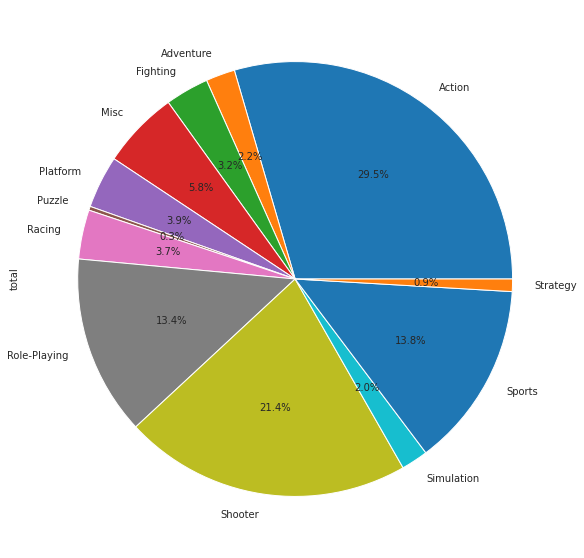

In [29]:
# жанры с высокими и низкими продажами
genre.plot(kind='pie',y='total', 
           labels=genre['genre'],figsize=(16,10),
           shadow=False, legend=False,autopct='%1.1f%%')

<AxesSubplot:ylabel='count'>

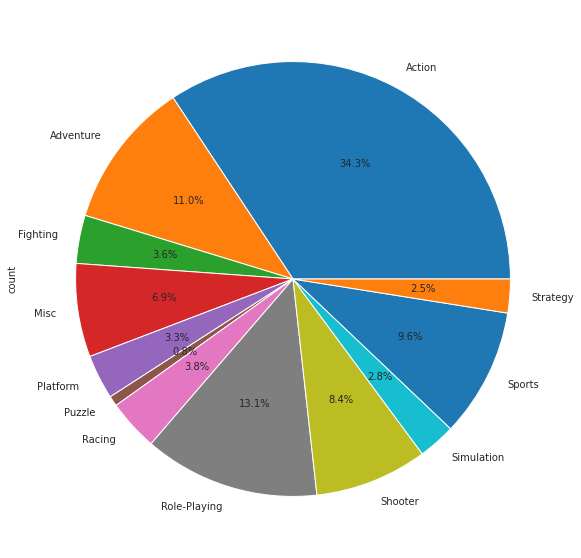

In [30]:
# распределение выпускаемых игр по жанрам
genre.plot(kind='pie',y='count', 
           labels=genre['genre'],figsize=(16,10),
           shadow=False, legend=False,autopct='%1.1f%%')


#### Вывод:
Больше всего игр выходит в жанре Action, на втором месте по количеству выпущенных игр жанр Role-Playing, 
далее следуют жанры Adventures и Sports, Shooter и Misc. Но топ самых прибыльных жанров несколько отличается.
Самый прибыльный жанр — Shooter, далее идет Sports, Platform, Role-Playing и Fighting. 
Интересно отсутствие жанра Action и Adventures в топе самых прибыльных игр.
При этом больше всего игр продается в жанрах: Action, Shooter и Sports немного отстает жанр Role-Playing.

## Портрет пользователя по регионам

  platform  eu_sales
3      PS4    141.09
2      PS3     67.81
7     XOne     51.59
6     X360     42.52
0      3DS     30.96
  platform  jp_sales
0      3DS     67.81
1      PS3     23.35
4      PSV     18.59
2      PS4     15.96
5     WiiU     10.88
  platform  na_sales
3      PS4    108.74
6     XOne     93.12
5     X360     81.66
2      PS3     63.50
0      3DS     38.20


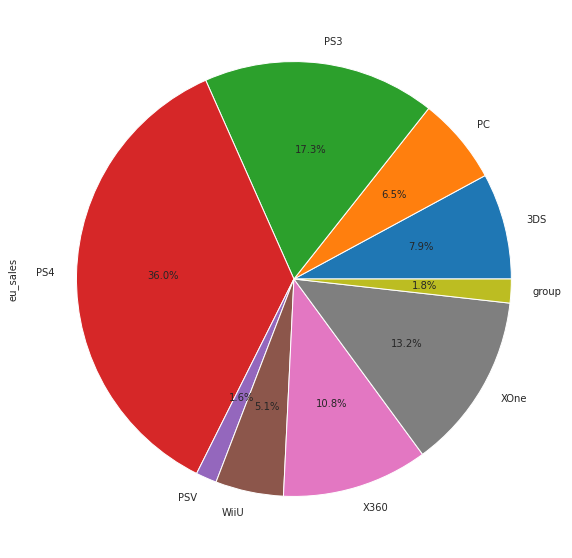

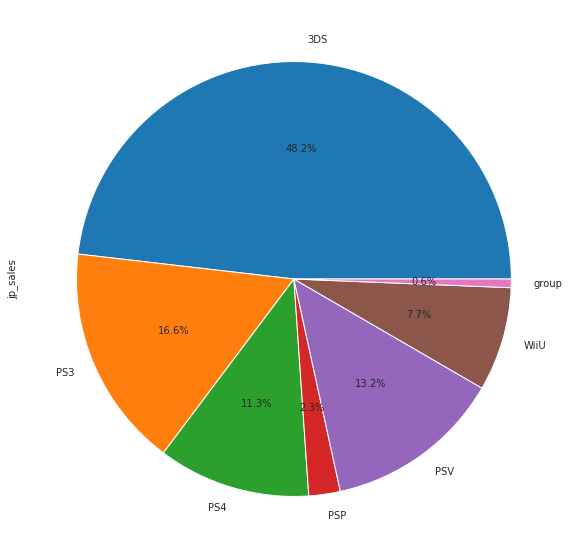

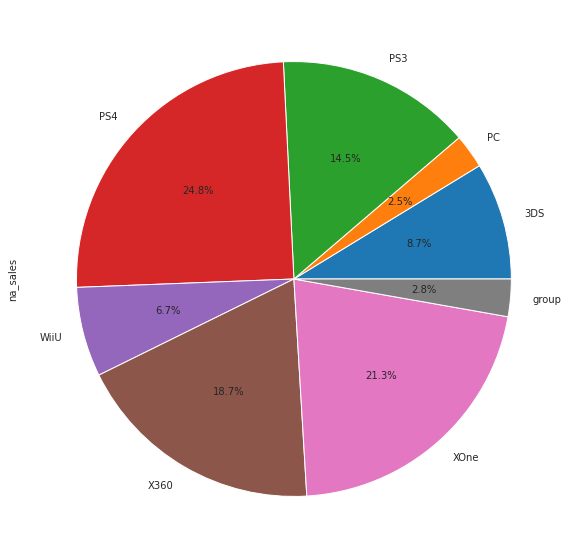

In [31]:
some_dict = ['eu_sales','jp_sales','na_sales']

for key in some_dict:
    data_direct=data.loc[data[key]>0]
    data_direct=data_direct.pivot_table(index='platform',values=key, aggfunc='sum')
    data_direct.reset_index(level=['platform'],inplace=True)
    min=data_direct[key].quantile([.25]).values[0]
    
    data_direct.loc[data_direct[key]<=min, 'platform']='group'
    data_direct=data_direct.pivot_table(index='platform',values=key, aggfunc='sum')
    data_direct.reset_index(level=['platform'],inplace=True)

    data_direct.plot(kind='pie',y=key, labels=data_direct['platform'],figsize=(16,10), shadow=False, legend=False,autopct='%1.1f%%') 
    
    print(data_direct.sort_values(by=key, ascending=False).head())

#### Вывод, платформы

Самая популярная платформа в Северной Америке — X360, в Европе — PS3, в Японии — DS
В Северной Америке в тройку по продажам входит PS3 и Wii, в Европе X360 и Wii, в Японии 3DS и PS3

На рынке Европы и Северной Америки в топе представлены одни и теже платформы, в Японии позици отличаются, например предствлен портативный консоль PSP

          genre  eu_sales
0        Action    118.13
6       Shooter     87.86
8        Sports     60.52
5  Role-Playing     36.97
4        Racing     20.19
          genre  jp_sales
5  Role-Playing     51.04
0        Action     40.49
3          Misc      9.20
2      Fighting      7.65
6       Shooter      6.61
          genre  na_sales
0        Action    126.05
7       Shooter    109.74
8        Sports     65.27
6  Role-Playing     46.40
3          Misc     27.49


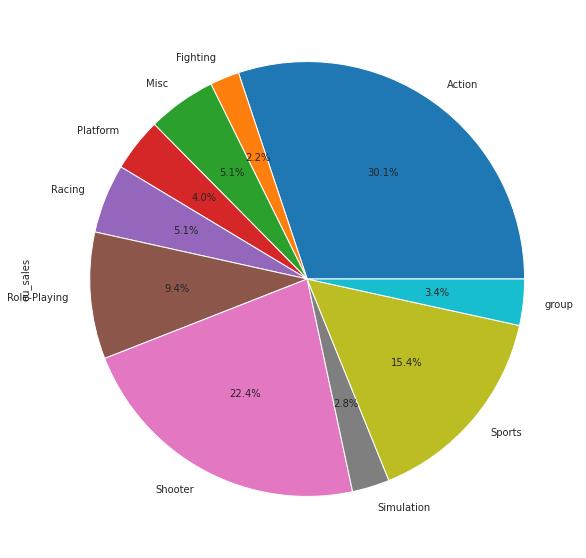

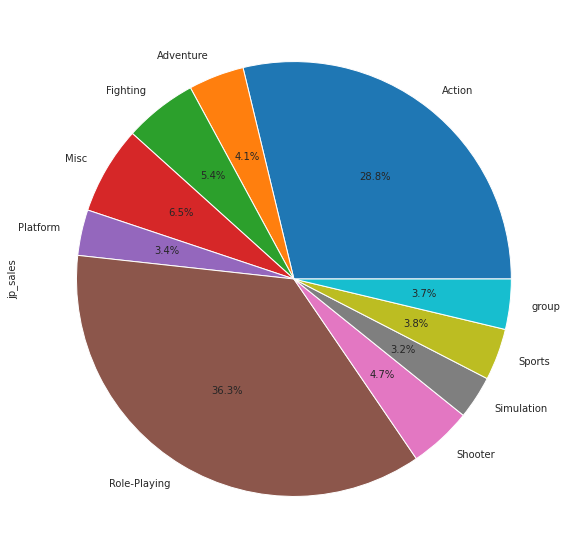

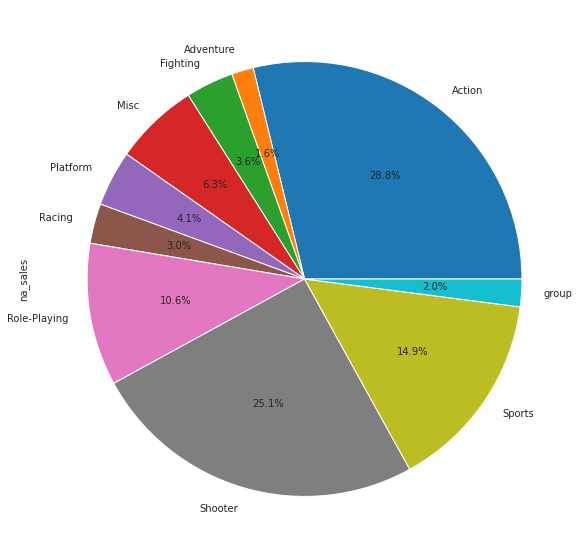

In [32]:
for key in some_dict:
    data_direct=data.loc[data[key]>0]
    data_direct=data_direct.pivot_table(index='genre',values=key, aggfunc='sum')
    data_direct.reset_index(level=['genre'],inplace=True)
    min=data_direct[key].quantile([.25]).values[0]
    
    data_direct.loc[data_direct[key]<=min, 'genre']='group'
    data_direct=data_direct.pivot_table(index='genre',values=key, aggfunc='sum')
    data_direct.reset_index(level=['genre'],inplace=True)

    data_direct.plot(kind='pie',y=key, labels=data_direct['genre'], 
                     figsize=(16,10), shadow=False, legend=False,autopct='%1.1f%%') 
    
    print(data_direct.sort_values(by=key, ascending=False).head())

#### Вывод, жанры

В Северной Америке и Европе топ-5 популярных жанров не отличаются, кроме последней позиции
в европе поплярнее гонки, в Америке — RPG
Японсикй рынок отличается — самый популярный жанр — RPG, также в топ-5 пояляется жанр misc и group.

In [33]:
data['rating'].unique()

array(['M', nan, 'E', 'T', 'E10+'], dtype=object)

In [34]:
data['rating'].isna().sum()

977

In [35]:
# заменил все пропущенные значения в столбце 'rating' на 'Non reiting' (заглушку)
# что позволит учитывать столбцы в анализе
data['rating'] = data['rating'].fillna(value='Non reiting')
data['rating'].isna().sum()

0

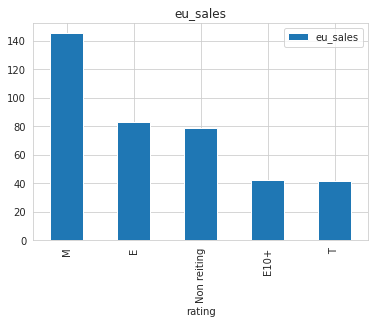

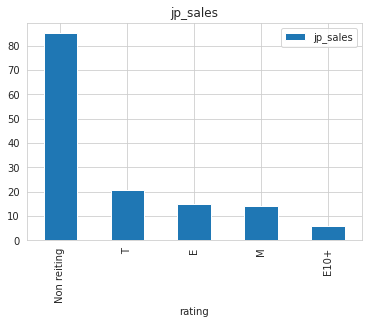

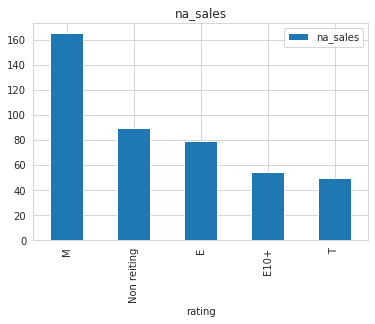

In [36]:
for region in some_dict:
    tmp_data = data[[region, 'rating']].copy()
    tmp_data = tmp_data.pivot_table(index='rating', 
                                    values=region, 
                                    aggfunc='sum').sort_values(by=region, 
                                                               ascending=False)
    tmp_data.plot(kind='bar')
    plt.title(region)
    plt.show()
    

#### Вывод, рейтинг ESRB

В Ееропе на первом месте по продажам игры с рейтингом — М (для взрослых), на втором игры с рейтингом — E (для всех)
совсем немного уступают игры без рейтинга ESRB (рейтинг обычно используется для стран Северной Америки, в Британии и большинстве стран Европы используют рейтинг PEGI). Игры для с возврастным ограничением старше 10 (E10+) игры для по подростков показывают одинаковые результатыт продаж.

В Японии с отрывом больше чем в 4 раза лидируют игры без рейтинга.
Далее идут игры для лиц старше 13 лет (T), для всех (E) и лиц старше 17 лет, далее игры для лиц старше 10 лет.


В Северной Америке на первом по продажам месте игры для взрослых (M), далее: игры без рейтинга, игры для всех (E), игры для детей старше 10 лет и игры для детей старше 13 лет.

In [43]:

temp = data.copy()
print(temp.rating.isna().sum(), temp.rating.isna().sum()/len(temp))
temp.rating.value_counts()

0 0.0


Non reiting    977
M              369
T              333
E              302
E10+           252
Name: rating, dtype: int64

In [38]:
data.head()

name platform  year_of_release         genre  \
16         Grand Theft Auto V      PS3             2013        Action   
23         Grand Theft Auto V     X360             2013        Action   
31  Call of Duty: Black Ops 3      PS4             2015       Shooter   
33        Pokemon X/Pokemon Y      3DS             2013  Role-Playing   
42         Grand Theft Auto V      PS4             2014        Action   

    na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
16      7.02      9.09      0.98         3.96          97.0         8.2   
23      9.66      5.14      0.06         1.41          97.0         8.1   
31      6.03      5.86      0.36         2.38           NaN         NaN   
33      5.28      4.19      4.35         0.78           NaN         NaN   
42      3.96      6.31      0.38         1.97          97.0         8.3   

         rating  total  
16            M  21.05  
23            M  16.27  
31  Non reiting  14.63  
33  Non reiting  14.60  
42            M  12.62

## Проверяем гипотезы

### Сравнение средних пользовательских рейтинги платформ Xbox One и PC
Условие нулевой гипотезы по сути написано в задании:
Среднее пользовательского рейтинга платформы Xbox One равно среднему пользовательскому рейтингу платформы PC
Альтернативная гипотеза: средние пользовательских рейтингов платформ Xbox One и PC не равны

In [39]:
data_xone=data.query('platform=="XOne"')
data_pc=data.query('platform=="PC"')

data_xone=data_xone[data_xone['user_score'].notna()]
data_pc=data_pc[data_pc['user_score'].notna()]

print('дисперсия XOne',np.var(data_xone['user_score']))
print('дисперсия PC',np.var(data_pc['user_score']))

alpha =0.05 

results = st.ttest_ind(
    data_xone['user_score'], 
    data_pc['user_score'])

print('p-значение:',results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

дисперсия XOne 1.8965188383045526
дисперсия PC 3.016306347554631
p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


### Сравнение средних пользовательских рейтингов жанров Action и Sports
Нулевая гипотеза:
Среднее пользовательского рейтинга жанра Action равно среднему пользовательскому рейтингу жанра Sports.

Альтернативная гипотеза:
Среднее пользовательского рейтинга жанра Action не равно среднему пользовательскому рейтингу Sports.

In [40]:
data_action=data.query('genre=="Action"')
data_sports=data.query('genre=="Sports"')

data_action=data_action[data_action['user_score'].notna()]
data_sports=data_sports[data_sports['user_score'].notna()]

print('дисперсия Action',np.var(data_action['user_score']))
print('дисперсия Sports',np.var(data_sports['user_score']))

alpha =0.05 

results = st.ttest_ind(
    data_action['user_score'], 
    data_sports['user_score'],
    equal_var = False)

print('p-значение:',results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

дисперсия Action 1.7648124186332366
дисперсия Sports 3.160733984375
p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


## Общий вывод

Популярные консоли меняются раз в 6-7 лет. 
В 2017 продолжится рост продаж игр на платформах: XOne, PS4, Wii
Но не стоит сбрасывать со счетов популярные платформы предыдущего поколения: X360, PS3 и WiiU
Данные показали зависимость между оценками экспертов и продажами игр.
Рынок Японии отличается от рынка Европы и Америки, как по жанру так и по выбору платформ
Основной объем продаж приходится в жанрах это Action и Shooter
Пользовательский рейтинг у жанра Action выше жанра Sports
Разницы в распределении рейтингов по платформам PC и XOne не найдено